<a href="https://colab.research.google.com/github/KhawajaMuddassar/Transfer-Learning/blob/main/transfer_learning_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Transfer Learning**

# **Introducing transfer learning**

Transfer learning is a technique where we transfer the learning of the model on generic dataset to the specific dataset of interest.OR in simple words Transfer learning is a technique where knowledge gained from one task is leveraged to solve another similar task.Typically, the pretrained models used to perform transfer learning are trained on millions of images (which are generic and not the dataset of interest to us) and those pretrained models are now fine-tuned to our dataset of interest.

We will practice two different families of transfer learning architectures - variants of **Visual Geometry Group (VGG)** architecture and variants of **Residual Network (ResNet)** architecture and thier application in two different
use cases, age and gender classification, where we will learn about optimizing over both cross-entropy and mean absolute error losses at the same time to estimate the age and predict the gender of a person (given an image of the person), and facial keypoint detection (detecting the keypoints like eyes,
eyebrows, and chin contour, given an image of a face as input).

The deep neural network architectures that we will go through in this chapter have been trained on the ImageNet dataset.

**High-Level Flow of Transfer Learning:**


1.   Normalize the input images, normalized by the same mean and standard deviation that was used during the training of the pretrained model.
2.   Fetch the pretrained model’s architecture. Fetch the weights for this architecture that arose as a result of being trained on a large dataset.
3.   Discard the last few layers of the pretrained model so that we can fine-tune the last layers for this specific dataset.
4.   Connect the truncated pretrained model to a freshly initialized layer (or layers) where weights are randomly initialized. Ensure that the output of the last layer has as many neurons as the classes/outputs we would want to predict.
5.   Ensure that the weights of the pretrained model are not trainable (in other words, frozen/not updated during backpropagation), but that the weights of the newly initialized layer and the weights connecting it to the output layer are trainable.

    We do not train the weights of the pretrained model, as we assume those weights are already well learned for the task, and hence leverage the learning from a large model. In summary, we only learn the newly initialized layers for our small dataset.
6.  Update the trainable parameters over increasing epochs to fit a model.



# **Understanding the VGG16 Architecture**

VGG stands for Visual Geometry Group, 16 stands for the number of layers in the model. The VGG16 model is trained to classify objects in the ImageNet competition and stood as the runner-up architecture in 2014.

There are ~138 million parameters (of which ~122 million are the linear layers at the end of the network - 102 + 16 + 4 million parameters) in this network, which comprises 13 layers of convolution and/or pooling, with an increasing number of filters, and 3 linear layers.

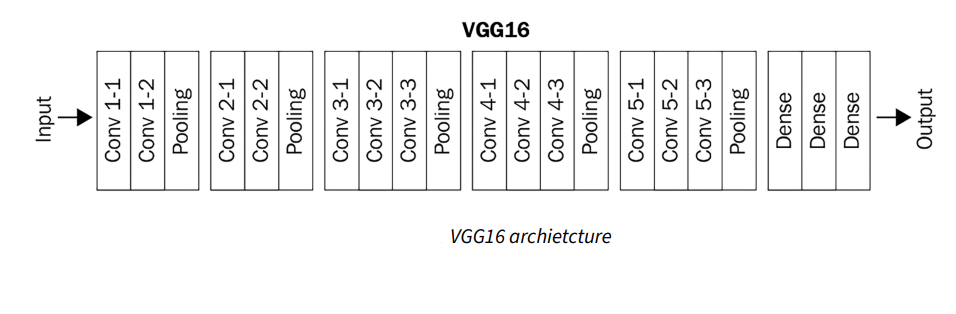

In [ ]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
!pip install torch_summary
from torchsummary import summary
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Load VGG16 model and register it to device
model = models.vgg16(pretrained=True).to(device) # pretrained=True mean we load weights that were used to classify images
summary(model, torch.zeros(1,3,224,224));

# **Implementing VGG16 for Cats Vs Dogs**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models, datasets
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt
from torch.optim import Adam
import numpy as np, cv2, pandas as pd, glob
from PIL import Image
from glob import glob
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Download Dataset and specify train and test directories

#1: Provide Kaggle athuntication tokken to download dataset by placing kaggle.json file in kaggle folder
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

#2: Download Dataset and Unzipp it
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip

#3: Specify training and test directories
train_data_directory = 'training_set/training_set'
test_data_directory = 'test_set/test_set'

# Define a class that return input-output pairs of cats and dogs
class CatsDogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder+'/cats/*.jpg')
        dogs = glob(folder+'/dogs/*.jpg')
        self.fpaths = cats[:500] + dogs[:500]
        self.normalize = transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]) # to normalize the image with same mean and std arose during training of pretrained model
        from random import shuffle, seed; seed(10)
        shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] # Dog=1, cat = 0
    def __len__(self): return len(self.fpaths)
    def __getitem__(self,xi):
        file = self.fpaths[xi]
        target = self.targets[xi]
        img = (cv2.imread(file)[:,:,::-1])
        img = cv2.resize(img,(224,224))
        img = torch.tensor(img/255)
        img = img.permute(2,0,1)
        img = self.normalize(img)
        return (img.float().to(device), torch.tensor([target]).float().to(device))

'''' Note: When leveraging pretrained models, it is mandatory to resize, permute, and then normalize images (as appropriate for that pretrained model),
where the images are first scaled to a value between 0 and 1 across the 3 channels and then normalized to a mean of [0.485, 0.456, 0.406] and
a standard deviation of [0.229, 0.224, 0.225] across the RGB channels'''

# Fetch Image and their labels
data = CatsDogs(train_data_directory)
img, label = data[200]
plt.imshow(img.permute(1,2,0).cpu())
print(label)


In [ ]:
# Download Pre-Trained model VGG16 from model class
def get_model():
    model = models.vgg16(pretrained=True)
# Freeze all parameters in model
    for param in model.parameters():
        param.requires_grad=False
    #Replace the avgpool module to return a feature map of size 1 x 1 instead of 7 x 7; in other words, the output is now going to be batch_size x 512 x 1 x 1
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
# nn.AdaptiveAvgPool2d, is yet another pooling layer with a twist, We specify the output feature map size instead.The layer automatically computes the kernel size so that the specified feature
# map size is returned For example, if the input feature map size dimensions were batch_size x 512 x k x k, then the pooling kernel size is going to be k x k.
# The major advantage of this layer is that whatever the input size, the output from this layer is always fixed and, hence, the neural network can accept images of any height and width.

#Define classifer module of methood, to flatten the output of AVGPOOL and connect 512 units to 128 units, and perform activation prior to output
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512,128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128,1),
        nn.Sigmoid()
        )
    loss_fn = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model.to(device), loss_fn, optimizer
model, criterion, optimizer = get_model()
summary(model, input_size=(3,224,224));

# Define function to train batch
def train_batch(x,y,model, loss, opt):
    model.train()
    pred = model(x)
    batch_loss = loss_fn(pred,y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

#Define the functions to calculate the accuracy
@torch.no_grad()
def accuracy(x,y,model):
    model.eval()
    with torch.no_grad():
        pred = model(x)
    accuracy = (pred>=0.5)==y
    return accuracy.cpu().numpy().tolist()

# Define function to fetch Data Loaders
def get_data():
    train_data = CatsDogs(train_data_directory)
    train_loader = DataLoader(train_data, batch_size = 32, shuffle=True, drop_last=True)
    val_data = CatsDogs(test_data_directory)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=True, drop_last=True)
    return train_loader, val_loader

# Initialize Get Data and Get model functions
train_data , val_data = get_data()
model, loss_fn, optimizer = get_model()

# Train Network
train_losses, train_accuracies = [], []
val_accuracies = []
for epoch in range(5):
    print(f" epoch {epoch + 1}/5")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(iter(train_data)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(train_data)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_data)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 72.8MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

<ipython-input-3-9ee8722ee034>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


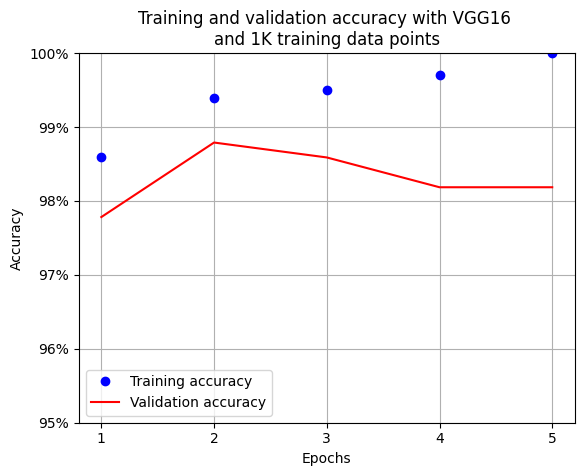

In [ ]:
# Plot the training and test accuracy values over increasing epochs
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with VGG16 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

# **Implementing facial keypoint detection - Multi-Regression Problem**

Imagine if we are asked to predict keypoints present on face of an image e-g location of eyes, nose and chin. so this is a task where we are predicting not one but sveral continous output which is a multiple-regression problem so we need to employ new strategy to build a model to detect the keypoints.

To solve this problem, we would first have to solve a few other problems:

1.   Images can be of different shapes. This warrants an adjustment in the keypoint locations while adjusting images to bring them all to a standard image size.
2.   Facial keypoints are similar to points on a scatter plot, but scattered based on a certain pattern this time. This means that the values are anywhere between 0 and 224 if the image is resized to a shape of 224 x 224 x 3.
3.   Normalize the dependent variable (the location of facial keypoints) as per the size of the image. The keypoint values are always between 0 and 1 if we consider their location relative to image dimensions.
4.  Given that the dependent variable values are always between 0 and 1, we can use a sigmoid layer at the end to fetch values that will be between 0 and 1

The pipeline for solving this facial keypoint detection is as follow.

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim import Adam
from glob import glob
import glob, numpy as np, cv2, pandas as pd ,os
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import importlib
mpl_toolkits = importlib.import_module('mpl_toolkits')
from mpl_toolkits.mplot3d import Axes3D
from random import shuffle, seed
from torchvision import transforms, models, datasets
from torchsummary import summary
from copy import deepcopy
from sklearn import cluster
%matplotlib inline
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Download and import relevant data that contain images and thier coresponding facial keypoints
!git clone https://github.com/udacity/P1_Facial_Keypoints.git
!cd P1_Facial_Keypoints
root_dir = 'P1_Facial_Keypoints/data/training/'
all_img_path = glob.glob(os.path.join(root_dir,'*.jpg'))
data = pd.read_csv('P1_Facial_Keypoints/data/training_frames_keypoints.csv')
#  column 1 represents the name of the image
# even columns represent the x-axis value corresponding to each of the 68 keypoints of the face
# odd columns (except the first column) represent the y-axis value corresponding to each of the 68 keypoints

# Define a dataface class which provide input and outpoints for data loader
class FaceData(Dataset):
    def __init__(self,df): # Takes dataframe of file as an input
        super(FaceData).__init__()
        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] ) #normalize images so that it can be consumed by VGG16
    def __len__(self): return len(self.df) # returns Datafram length
    def __getitem__(self,xi): #fetch the path of image for given index
        img_path = 'P1_Facial_Keypoints/data/training/'+self.df.iloc[xi,0]
        img = cv2.imread(img_path)/255. # Scale the image
        #Normalize the expected output values (keypoints) as a proportion of the size of the original image. Means if we resize the image location of keypoint will not change
        kp = deepcopy(self.df.iloc[xi,1:].tolist())
        kp_x = (np.array(kp[0::2])/img.shape[1]).tolist()
        kp_y = (np.array(kp[1::2])/img.shape[0]).tolist()
        # return kp2 and image after pre-processing
        kp2 = kp_x + kp_y
        kp2 = torch.tensor(kp2)
        img = self.preprocess_input(img)
        return img, kp2
    def preprocess_input(self,img): # to preprocess the image
        img = cv2.resize(img,(224,224))
        img = torch.tensor(img).permute(2,0,1)
        img = self.normalize(img).float()
        return img.to(device)
    def load_image(self,xi): # to load test images for visualiztion and keypoint predictions
        img_path = 'P1_Facial_Keypoints/data/training/'+self.df.iloc[xi,0]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
        img = cv2.resize(img, (224,224))
        return img

# create train and test data splits to establish datasets and dataloaders

# Data Splits
train, test = train_test_split(data, test_size=0.2, random_state=101)
train_dataset = FaceData(train.reset_index(drop=True))
test_dataset = FaceData(test.reset_index(drop=True))
#Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define function to load pretrained model and fine-tune according to our needs
def get_model():
    model = models.vgg16(pretrained=True)
    # Freeze model's parameters
    for param in model.parameters():
        param.requires_grad=False
    #Overwrite and unfreeze the parameters of the last two layers of the model
    model.avgpool = nn.Sequential(
        nn.Conv2d(512,512,3),
        nn.MaxPool2d(2),
        nn.Flatten()
    )
    model.classifier = nn.Sequential(
        nn.Linear(2048, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512,136),
        nn.Sigmoid() # returns a value between 0 and 1
    )
    criterion = nn.L1Loss() # Mean Absolute Error reduction on the prediction of the location of facial keypoints - predicted as a percentage of the image’s width and height
    optimizer = Adam(model.parameters(), lr=1e-4)
    return model.to(device), criterion, optimizer

# Initialize model
model, criterion, optimizer = get_model()
#summary(model, input_size=(3,224,224));

#Training Batch
def train_batch(img, kps, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    _kps = model(img.to(device))
    loss = criterion(_kps, kps.to(device))
    loss.backward()
    optimizer.step()
    return loss

#Function for loss on test data and predicted keypoints
@torch.no_grad()
def validate_batch(img, kps, model,criterion):
    model.eval()
    _kps = model(img.to(device))
    loss = criterion(_kps, kps.to(device))
    return _kps, loss

# Train Network on Training Dataloader and test it on test data
train_loss, test_loss =[],[]
epochs = 50

for epoch in range(epochs):
    print(f'epoch : {epoch+1} of {epochs} ')
    train_epoch_loss, test_epoch_loss = 0,0

    # For training Data
    for xi, (img,kps) in enumerate(train_loader):
        loss = train_batch(img,kps, model,criterion, optimizer)
        train_epoch_loss +=loss.item()
    train_epoch_loss /= (xi+1)

    # For testing Data
    for xi, (img,kps) in enumerate(test_loader):
        ps, loss = validate_batch(img, kps, model, criterion)
        test_epoch_loss += loss.item()
    test_epoch_loss /= (xi+1)

    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)

epochs = np.arange(50)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()


ix = 0
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
im = test_dataset.load_image(ix)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)
plt.title('Image with facial keypoints')
x, _ = test_dataset[ix]
plt.imshow(im)
kp = model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.show()

# **Implementing age estimation and gender classification - Multi-task learning**

**Multi-task learning**, which is a branch of research where sigle/few inputs are used to predict different but connected output. For example, in a self-driving car, the model needs to identify obstacles, plan routes, and give the right amount of throttle/brake and steering, to name but a few. It needs to do all of these in a split second by considering the same set of inputs. Furthermore, multi-task learning helps in learning domain-specific features that can be cross-leveraged across different tasks, potentially within the same domain.

Is this example we will predict age and gender of person in given image in a single shot which means we will predict both continsous and catigorical variables.

In [ ]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchvision import transforms, models, datasets
from matplotlib import pyplot as plt
from glob import glob
from random import shuffle, seed
import glob
import numpy as np, pandas as pd, cv2, glob, os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Fetch The Dataset
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def getfile_from_drive(file_id, name):
    download = drive.CreateFile({'id':file_id})
    download.GetContentFile(name)

getfile_from_drive('1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86', 'fairface-img-margin025-trainval.zip')
getfile_from_drive('1k5vvyREmHDW5TSM9QgB04Bvc8C8_7dl-', 'fairface-label-train.csv')
getfile_from_drive('1_rtz1M1zhvS0d5vVoXUamnohB6cJ02iJ', 'fairface-label-val.csv')

!unzip --qq fairface-img-margin025-trainval.zip

train_df = pd.read_csv('fairface-label-train.csv')
val_df = pd.read_csv('fairface-label-val.csv')
train_df.head(5)


In [ ]:

# Define gander age class , which takes filename as input and return coresponding image, gender and scaled age ( age scaled to avoid vanshiing gradients)
img_size = 224
class GenderAgeClass(Dataset):
    def __init__(self,df, tfms=None):
        self.df = df
        self.normalize = transforms.Normalize(
                                              mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
    def __len__(self): return len(self.df) # returns the number of images in the input
    def __getitem__(self,xi): # fetches information of an image at a given position xi
        f = self.df.iloc[xi].squeeze()
        file = f.file
        gen = f.gender == 'Female'
        age = f.age
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img, age, gen
    # Define function to preprocess image i-e resizing, converting to torch object,permuting the channels and normalizing image.
    def preprocess_image(self,img):
        img = cv2.resize(img, (img_size,img_size))
        img = torch.tensor(img).permute(2,0,1)
        img = self.normalize(img/255.)
        return img[None]

    # Define Collate_fn methood to fetch batch of data where datapoints are pre-processed
        # 1: Process each image using the process_image method
        # 2: Scale the age by 80 (the maximum age value present in the dataset), so that all values are between 0 and 1
        # 3: Convert gender to a float value
        # 4: image, age, and gender are each converted into torch objects and returned
    def collate_fn(self, batch):
        'Pre-process images, ages, genders'
        imgs, ages, genders = [], [] ,[]
        for img, age, gender in batch:
            img = self.preprocess_image(img)
            imgs.append(img)
            ages.append(float(int(age)/80))
            genders.append(float(gender))
        ages, genders  = [ torch.tensor(x).float().to(device) for x in [ages, genders]]
        imgs = torch.cat(imgs).to(device)
        return imgs, ages, genders

# Define Training and validation dataset and DataLoaders
train = GenderAgeClass(train_df)
val = GenderAgeClass(val_df)

train_loader = DataLoader(train, batch_size=32, shuffle=True, drop_last=True, collate_fn=train.collate_fn)
val_loader = DataLoader(val, batch_size=32, collate_fn=val.collate_fn)
a, b, c, = next(iter(train_loader))
#print(a.shape, b.shape, c.shape)

# Define model , loss and optimizer
def get_model():
    model = models.vgg16(pretrained=True)
    #freeze all parameters
    for param in model.parameters():
        param.requires_grad=False
    #Overwrite avgpool with our fine-tuned layer
    model.avgpool = nn.Sequential(
        nn.Conv2d(512,512,kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten()
    )
    # Keypart: Create two branch of output
        # Build a Neural network class
    class AgeGenderClassifier(nn.Module):
        def __init__(self):
            super(AgeGenderClassifier,self).__init__()
            # Define calculations (intermediate layers)
            self.intermediate = nn.Sequential(
                nn.Linear(2048,512),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(512,128),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(128,64),
                nn.ReLU(),
            )
            # Define Age and Gender Classifiers (Last Layers)
            self.age_classifier = nn.Sequential(
                nn.Linear(64,1),
                nn.Sigmoid()
            )
            self.gender_classifier = nn.Sequential(
                nn.Linear(64,1),
                nn.Sigmoid()
            )
        def forward(self,x): # Forward pass to stack layers
            x = self.intermediate(x)
            age = self.age_classifier(x)
            gender = self.gender_classifier(x)
            return gender , age
    # Overwrite classifier moudle in VGG16 pretrain model by fine-tuned classifer
    model.classifier = AgeGenderClassifier()
    gender_criterion = nn.BCELoss()
    age_criterion = nn.L1Loss()
    loss_fn = gender_criterion , age_criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    return model.to(device), loss_fn, optimizer

# Initialize the model to have values in variables
model, loss_fn, optimizer = get_model()

# Summary of fine-tuned model
from torchsummary import summary
#summary(model, input_size=(3,224,224))

# Define function to train and validate on batch of data on dataset
def train_batch(data, model, optimizer, criteria):
    model.train()
    img, age, gender = data
    optimizer.zero_grad()
    pred_gender, pred_age = model(img)
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(),age)
    total_loss = gender_loss + age_loss
    total_loss.backward() # Back propogation to reduce overall loss
    optimizer.step()

    return total_loss

# Define validate batch of data
def validate_batch(data, model, criteria):
    model.eval()
    img, age, gender = data
    with torch.no_grad():
        pred_gender, pred_age  =model(img)
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_gender.squeeze(), gender) # Squeezed prediction which has shape of (batch size, 1), reshaped to original img (only batch size)
    age_loss = age_criterion(pred_age.squeeze(), age)
    total_loss = gender_loss + age_loss
    pred_gender = (pred_gender > 0.5).squeeze() # Finial predicted gender class
    gender_accuracy = (pred_gender == gender).float().sum()
    age_mae = torch.abs(age - pred_age).float().sum()
    return total_loss, gender_accuracy, age_mae

# Train Network over 5 epochs
    # Define placeholders to store train and test loss
import time
model, criteria, optimizer = get_model()
train_losses, val_losses, val_gender_accuracy, val_age_mae = [],[],[],[]
epochs = 5
best_test_loss = 1000
start = time.time()

for epoch in range(epochs):
    # Reinitialze train & val loss values
    epoch_train_losses, epoch_val_losses = 0,0
    val_gender_accuracies, val_age_maes, ctr = 0,0,0
    _n = len(train_loader)

    # For Training DataLoader
    for xi, data in enumerate(iter(train_loader)):
        loss = train_batch(data, model,  optimizer,criteria)
        epoch_train_losses += loss.item()

    # For Validation DataLoader, also calc. gender accuracy and age MAE
    for xi, data in enumerate(iter(val_loader)):
        loss, gender_acc, age_mae = validate_batch(data,model, criteria)
        epoch_val_losses += loss.item()
        val_age_maes += age_mae
        val_gender_accuracies += gender_acc
        ctr += len(data[0])

    # Overall accuracy of age prediction and gender classification
    val_age_maes /= ctr
    val_gender_accuracies /= ctr
    epoch_train_losses /=len(train_loader)
    epoch_val_losses /= len(val_loader)

    # Log Metrics for each epoch
    elapsed = time.time() - start
    best_test_loss = min(best_test_loss , epoch_val_losses)
    print('{}/{} ({:.2f}s - {:.2f}s remaining)'.format(epoch+1, epochs, time.time()-start, (epochs-epoch)*(elapsed/(epoch+1))))
    info = f'''Epoch: {epoch+1:03d}\tTrain Loss: {epoch_train_losses:.3f}\tTest: {epoch_val_losses:.3f}\tBest Test Loss: {best_test_loss:.4f}'''
    info += f'\nGender Accuracy: {val_gender_accuracies*100:.2f}%\tAge MAE: {val_age_maes:.2f}\n'
    print(info)

    # Age and Gender accuracy of the test dataset in each epoch
    val_gender_accuracy.append(val_gender_accuracies)
    val_age_mae.append(val_age_maes)


1/5 (689.42s - 3447.10s remaining)
Epoch: 001	Train Loss: 0.550	Test: 0.467	Best Test Loss: 0.4668
Gender Accuracy: 83.13%	Age MAE: 5.99

2/5 (1387.26s - 2774.51s remaining)
Epoch: 002	Train Loss: 0.401	Test: 0.447	Best Test Loss: 0.4471
Gender Accuracy: 84.53%	Age MAE: 6.35

3/5 (2094.23s - 2094.23s remaining)
Epoch: 003	Train Loss: 0.283	Test: 0.498	Best Test Loss: 0.4471
Gender Accuracy: 84.27%	Age MAE: 6.30

4/5 (2724.88s - 1362.44s remaining)
Epoch: 004	Train Loss: 0.197	Test: 0.606	Best Test Loss: 0.4471
Gender Accuracy: 84.12%	Age MAE: 6.25

5/5 (3355.10s - 671.02s remaining)
Epoch: 005	Train Loss: 0.158	Test: 0.774	Best Test Loss: 0.4471
Gender Accuracy: 83.35%	Age MAE: 6.33



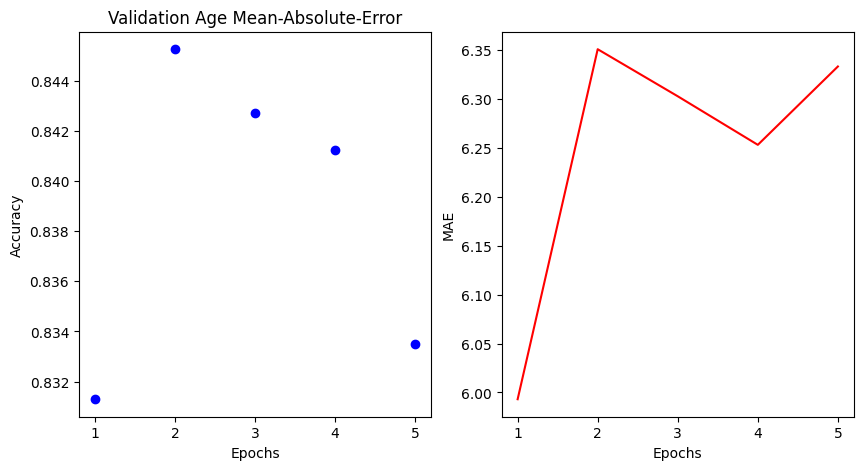

In [ ]:
# Plot the accuracy of age estimation and gender prediction over increasing epochs
epochs = np.arange(1,len(val_gender_accuracy)+1)
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax = ax.flat
ax[0].plot(epochs, [v.item() for v in val_gender_accuracy], 'bo')
ax[1].plot(epochs, [v.item() for v in val_age_mae], 'r')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[1].set_ylabel('MAE')
ax[0].set_title('Validation Gender Accuracy')
ax[0].set_title('Validation Age Mean-Absolute-Error')
plt.show()

In [ ]:
# Make predictions on random images

#!wget

# Load image and pre-process
img = cv2.imread('/content/boy.jpg')
img = train.preprocess_image(img).to(device)

# Pass image through trained model
gender, age = model(img)
pred_gender = gender.to('cpu').detach().numpy()
pred_age = age.to('cpu').detach().numpy()

# Plot image along with predicted gender and age
img = cv2.imread('/content/boy.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
print('predicted gender:',np.where(pred_gender[0][0]<0.5, 'Male','Female'), '; Predicted age', int(pred_age[0][0]*80))
